# Welcome to the Seoul Bike Project

In this project, I will use regression and deep learning techniques to predict the number of bikes needed to be available on a certain day based on a number of factors. The dataset is taken from the publicly avaiable Machine Learning Repository https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand. 

## Part 1.1: Exploring the data.

First we import the libraries needed. 

In [138]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, accuracy_score

import tensorflow as tf

import math

We manually download the dataset, and load it using Pandas. We then explore the data a bit to see if there are any inconsistencies or features/values that we need to be careful with.

In [18]:
df = pd.read_csv('SeoulBikeData.csv', encoding= 'unicode_escape')
df.tail()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
8755,30/11/2018,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,Yes
8756,30/11/2018,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8757,30/11/2018,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8758,30/11/2018,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes
8759,30/11/2018,584,23,1.9,43,1.3,1909,-9.3,0.0,0.0,0.0,Autumn,No Holiday,Yes


Checking for null values..

In [19]:
df.isnull().sum()

Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64

Using the .describe method, we inform ourself about the distributions of the numerical fields in the DataFrame. We can see that some fields have high variance and are somewhat skewed to either the left or right. A machine learning model wants to have neatly fitted normal distributions as input. We will come back to this later.

In [20]:
df.describe()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


#Part 1.2: The categorical fields. 

We want to map the categorical fields to normal distributions. Firstly, we map the date to a number of the week. Secondly, we map all categorical values to dummy variables (aka one-hot encodings). Thirdly, we drop the Date column, because the Weekday column already posses aggregated information about the date. The categorical fields are now all mapped to binary columns, perfect for machine learning! We define a new DateFrame called df_processed. 

In [145]:
df['Weekday'] = [datetime.datetime.strptime(date, '%d/%m/%Y').weekday() for date in df['Date']] #monday = 0, sunday = 6
df_processed = pd.get_dummies(data=df, columns=['Weekday', 'Hour', 'Seasons', 'Holiday', 'Functioning Day'])
df_processed.drop(['Date'], axis=1, inplace=True)

#Part 1.3: The numerical fields. 

Unfortunately, translating the numerical fields to something that easy to model is not as straightforward as the categorical fields. We first want to see how each distribution looks like. This is done using the matplotlib library. 

array([[<Axes: title={'center': 'Rented Bike Count'}>,
        <Axes: title={'center': 'Temperature(°C)'}>,
        <Axes: title={'center': 'Humidity(%)'}>],
       [<Axes: title={'center': 'Wind speed (m/s)'}>,
        <Axes: title={'center': 'Visibility (10m)'}>,
        <Axes: title={'center': 'Dew point temperature(°C)'}>],
       [<Axes: title={'center': 'Solar Radiation (MJ/m2)'}>,
        <Axes: title={'center': 'Rainfall(mm)'}>,
        <Axes: title={'center': 'Snowfall (cm)'}>]], dtype=object)

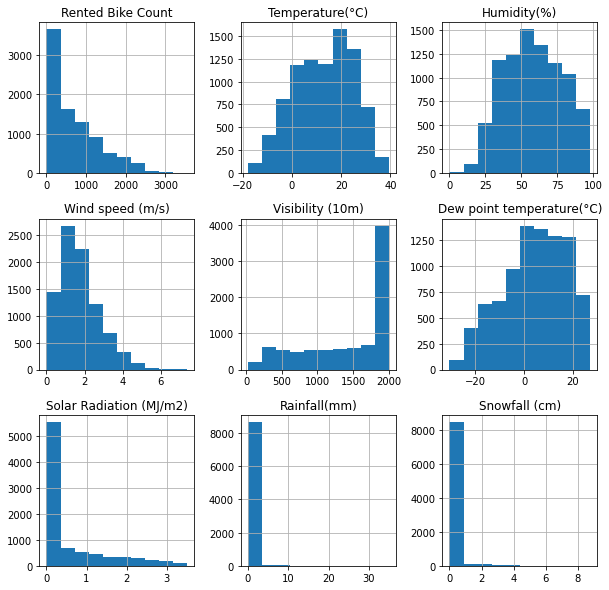

In [146]:
#df_processed_hist = df_processed.iloc[:,:9]
#number = 9
#column = df_processed_hist.columns[number]
#plt.hist(x=df_processed_hist[column])
#plt.xlabel(column)
#plt.ylabel('Frequency')      
#plt.show()

df_processed_hist = df_processed.iloc[:,:9]
df_processed_hist.hist(figsize=(10,10))

We can make a couple of obervations:
- 'Rented Bike Count' is heavily skewed to the left and is >= 0
- 'Temperature' already acts somewhat like a normal distribution
- 'Humidity' already acts somewhat like a normal distribution
- 'Wind speed' is heavily skewed to the left and is >= 0
- 'Visibility' is heavily skewed to the right and is >= 0
- 'Dew point temperature' is skewed to the right
- 'Solar Radiation' is heavily skewed to the left and is >= 0
- 'Rainfall' is extremely skewed to the left and is >= 0
- 'Snowfall' is extremely skewed to the left and is >= 0

From this we can apply the following scaling:
- 'Rented Bike Count' -> Box-Cox
- 'Temperature' -> Standard Scaler
- 'Humidity' -> Standard Scaler
- 'Wind speed' -> Box-Cox
- 'Visibility' -> Box-Cox
- 'Dew point temperature' -> We cant use Box-Cox because of negative values, we instead use a -> Standard Scaler
- 'Solar Radiation' -> Box-Cox
- 'Rainfall' is extremely -> Box-Cox
- 'Snowfall' is extremely -> Box-Cox

Setting up the MinMax and BoxCox scalers for every column.

In [147]:
boxcox_rentedbike = PowerTransformer(method='box-cox')
boxcox_windspeed = PowerTransformer(method='box-cox')
boxcox_visibility = PowerTransformer(method='box-cox')
boxcox_solarrad = PowerTransformer(method='box-cox')
boxcox_rain = PowerTransformer(method='box-cox')
boxcox_snow = PowerTransformer(method='box-cox')
minmax_temp = StandardScaler()
minmax_humidity = StandardScaler()
boxcox_dewpoint = StandardScaler()

df_processed['Rented Bike Count'] = boxcox_rentedbike.fit_transform(np.array(df_processed['Rented Bike Count'].apply(lambda x : x+1)).reshape(-1,1)) #x+1 because we cant have zero values.
df_processed['Wind speed (m/s)'] = boxcox_windspeed.fit_transform(np.array(df_processed['Wind speed (m/s)'].apply(lambda x : x+1)).reshape(-1,1))
df_processed['Visibility (10m)'] = boxcox_visibility.fit_transform(np.array(df_processed['Visibility (10m)'].apply(lambda x : x+1)).reshape(-1,1))
df_processed['Solar Radiation (MJ/m2)'] = boxcox_solarrad.fit_transform(np.array(df_processed['Solar Radiation (MJ/m2)'].apply(lambda x : x+1)).reshape(-1,1))
df_processed['Rainfall(mm)'] = boxcox_rain.fit_transform(np.array(df_processed['Rainfall(mm)'].apply(lambda x : x+1)).reshape(-1,1))
df_processed['Snowfall (cm)'] = boxcox_snow.fit_transform(np.array(df_processed['Snowfall (cm)'].apply(lambda x : x+1)).reshape(-1,1))
df_processed['Temperature(°C)'] = minmax_temp.fit_transform(np.array(df_processed['Temperature(°C)']).reshape(-1,1))
df_processed['Humidity(%)'] = minmax_humidity.fit_transform(np.array(df_processed['Humidity(%)']).reshape(-1,1))
df_processed['Dew point temperature(°C)'] = boxcox_dewpoint.fit_transform(np.array(df_processed['Dew point temperature(°C)']).reshape(-1,1))

Now we check if these transformations have actually worked:

array([[<Axes: title={'center': 'Rented Bike Count'}>,
        <Axes: title={'center': 'Temperature(°C)'}>,
        <Axes: title={'center': 'Humidity(%)'}>],
       [<Axes: title={'center': 'Wind speed (m/s)'}>,
        <Axes: title={'center': 'Visibility (10m)'}>,
        <Axes: title={'center': 'Dew point temperature(°C)'}>],
       [<Axes: title={'center': 'Solar Radiation (MJ/m2)'}>,
        <Axes: title={'center': 'Rainfall(mm)'}>,
        <Axes: title={'center': 'Snowfall (cm)'}>]], dtype=object)

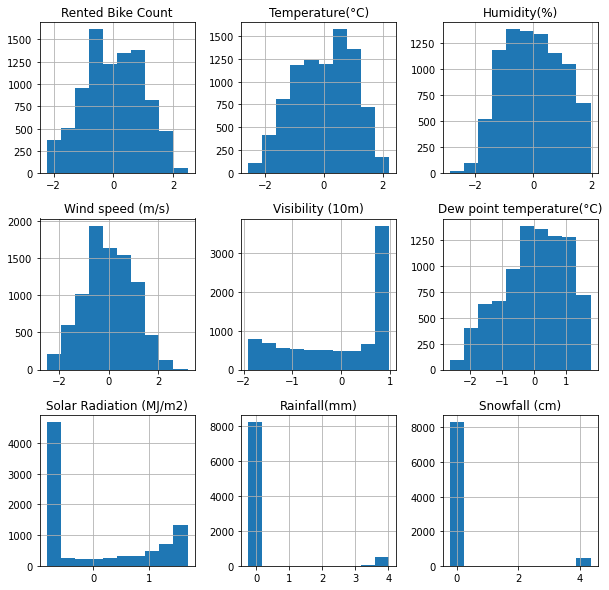

In [148]:
df_processed_hist = df_processed.iloc[:,:9]
df_processed_hist.hist(figsize=(10,10))

That is better! But it can certainly be improved... A possible solution would be to bin the values of the extremely skewed distributions - or to remove them altogether, since most of the values are zero anyways.

## Part 2.1: Using Scikit-Learn to predict the number of bikes that need to be available. 

Let us define the feature values X and the target values y. And using the train_test_split function, we define the training set and the test set. There is some debate in the data science community whether one should put the train_test split infront or after the scaling. As you can see, I also performed Principal Component Analysis to reduce the dimensionality. But this only resulted in worse results. We perform Multiple Linear Regression on the preprocessed data. 

In [190]:
X = df_processed.drop('Rented Bike Count', axis=1)
y = df_processed['Rented Bike Count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

#pca = PCA(n_components = 20) #47 to 20 features
#X_train = pca.fit_transform(X_train)
#X_test = pca.transform(X_test)

#kpca = KernelPCA(n_components = 20, kernel = 'rbf')
#X_train = kpca.fit_transform(X_train)
#X_test = kpca.transform(X_test)

LR = LinearRegression()
LR.fit(X_train, y_train)
predictions = LR.predict(X_test)
#y_test = boxcox_rentedbike.inverse_transform(np.array(y_test).reshape(-1,1))
#predictions = boxcox_rentedbike.inverse_transform(predictions.reshape(-1,1))

LinearRegression_MAE = mean_absolute_error(predictions, y_test)
LinearRegression_MSE = mean_squared_error(predictions, y_test)
LinearRegression_R2 = r2_score(predictions, y_test)
Report = pd.DataFrame({'MAE': LinearRegression_MAE, 'MSE' : LinearRegression_MSE, 'R2' : LinearRegression_R2}, index=[0])
Report

,MAE,MSE,R2
0,0.334317,0.19268,0.769627


We obtain a 'low' mean squared error and 'high' R2 score. This is somewhat good, but it can be improved for sure. Lets look at the actual predicted values, versus the original values. 

In [192]:
y_test_inv = boxcox_rentedbike.inverse_transform(np.array(y_test).reshape(-1,1))
predictions_inv = boxcox_rentedbike.inverse_transform(predictions.reshape(-1,1))
list(zip(y_test_inv, predictions_inv))[:30]

[(array([32.]), array([12.11539951])),
 (array([906.]), array([682.95007129])),
 (array([1376.]), array([795.35064215])),
 (array([1108.]), array([982.0817491])),
 (array([415.]), array([387.98323504])),
 (array([530.]), array([142.57471767])),
 (array([241.]), array([169.18774647])),
 (array([1032.]), array([1131.76068317])),
 (array([116.]), array([118.43252039])),
 (array([447.]), array([451.00372443])),
 (array([1081.]), array([766.17970527])),
 (array([783.]), array([616.16415603])),
 (array([838.]), array([873.0297876])),
 (array([1.]), array([22.17377798])),
 (array([302.]), array([333.98864906])),
 (array([1235.]), array([1305.52783029])),
 (array([813.]), array([1823.11219845])),
 (array([235.]), array([307.29341904])),
 (array([782.]), array([531.46812535])),
 (array([702.]), array([412.00689214])),
 (array([280.]), array([264.7202036])),
 (array([1936.]), array([1581.26479013])),
 (array([1.]), array([25.07408074])),
 (array([1866.]), array([2184.98620402])),
 (array([876.])

As we can see, the model is sometimes very close (20 bikes) away from the true value. But sometimes it can also completely miss the mark. 

## Part 2.2: Using Keras to predict the number of bikes that need to be available. 



Now, lets design a simple deep neural network using the Keras API. We hope that this network will outperform the general multiple linear regression. 

The input shape is (47,) because we have 47 columns. The model begins with a large amount of neurons (to increase overfitting), and uses embedding to lower the dimensions. In a deep MLP network, Relu are used most often. I have chosen for the Leaky Relus. The output activation is linear.

In [186]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(47,)))
model.add(tf.keras.layers.Dense(64,use_bias=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
model.add(tf.keras.layers.Dense(64,use_bias=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
model.add(tf.keras.layers.Dense(64,use_bias=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
model.add(tf.keras.layers.Dense(32,use_bias=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
model.add(tf.keras.layers.Dense(16,use_bias=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
model.add(tf.keras.layers.Dense(1, activation='linear'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                3072      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 32)               

In [187]:
optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
loss=tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)
# This builds the model for the first time:
model.fit(X_train, y_train, batch_size=16, epochs=20)

Epoch 1/20
438/438 [==============================] - 2s 2ms/step - loss: 0.2471
Epoch 2/20
438/438 [==============================] - 1s 2ms/step - loss: 0.1137
Epoch 3/20
438/438 [==============================] - 1s 2ms/step - loss: 0.0924
Epoch 4/20
438/438 [==============================] - 1s 2ms/step - loss: 0.0755
Epoch 5/20
438/438 [==============================] - 2s 3ms/step - loss: 0.0659
Epoch 6/20
438/438 [==============================] - 1s 3ms/step - loss: 0.0622
Epoch 7/20
438/438 [==============================] - 1s 2ms/step - loss: 0.0599
Epoch 8/20
438/438 [==============================] - 1s 2ms/step - loss: 0.0554
Epoch 9/20
438/438 [==============================] - 1s 2ms/step - loss: 0.0561
Epoch 10/20
438/438 [==============================] - 1s 2ms/step - loss: 0.0514
Epoch 11/20
438/438 [==============================] - 1s 2ms/step - loss: 0.0514
Epoch 12/20
438/438 [==============================] - 1s 2ms/step - loss: 0.0497
Epoch 13/20
438/438 [====

In [193]:
predictions = model.predict(X_test)
LinearRegression_MAE = mean_absolute_error(predictions, y_test)
LinearRegression_MSE = mean_squared_error(predictions, y_test)
LinearRegression_R2 = r2_score(predictions, y_test)
Report = pd.DataFrame({'MAE': LinearRegression_MAE, 'MSE' : LinearRegression_MSE, 'R2' : LinearRegression_R2}, index=[0])
Report

55/55 [==============================] - 0s 1ms/step


,MAE,MSE,R2
0,0.156399,0.059986,0.937104


The MSE and R2 scores are exceptionally better!

In [194]:
y_test_inv = boxcox_rentedbike.inverse_transform(np.array(y_test).reshape(-1,1))
predictions_inv = boxcox_rentedbike.inverse_transform(predictions.reshape(-1,1))
list(zip(y_test_inv, predictions_inv))[:30]

[(array([32.]), array([29.253876], dtype=float32)),
 (array([906.]), array([1037.4684], dtype=float32)),
 (array([1376.]), array([1375.5685], dtype=float32)),
 (array([1108.]), array([993.85254], dtype=float32)),
 (array([415.]), array([378.33505], dtype=float32)),
 (array([530.]), array([179.92902], dtype=float32)),
 (array([241.]), array([248.85132], dtype=float32)),
 (array([1032.]), array([1383.9961], dtype=float32)),
 (array([116.]), array([139.397], dtype=float32)),
 (array([447.]), array([424.4144], dtype=float32)),
 (array([1081.]), array([905.73236], dtype=float32)),
 (array([783.]), array([631.1666], dtype=float32)),
 (array([838.]), array([885.41614], dtype=float32)),
 (array([1.]), array([0.9403291], dtype=float32)),
 (array([302.]), array([351.30582], dtype=float32)),
 (array([1235.]), array([997.6461], dtype=float32)),
 (array([813.]), array([1143.4417], dtype=float32)),
 (array([235.]), array([270.63965], dtype=float32)),
 (array([782.]), array([760.70276], dtype=float32

As you can see, these results are exceptionally better than the ones from the MLR model!